In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split 

In [80]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [81]:
from pandas_profiling import ProfileReport

In [82]:
data = pd.read_csv("../../../kickstarter_dataset/ks-projects-201612-raw.csv",encoding='windows-1252')

## Explore the dataset for a bit

- looks like the last few columns only have NaN values: is this an error reading the file?
- remove the white space in the column names
- use the state as the label
- consider doing some subtraction to make a column funding_length = start - end

In [83]:
# drop NaN data; this is confirmed by looking back to the csv file
data = data.drop(columns = ["Unnamed: 13", "Unnamed: 14", "Unnamed: 15","Unnamed: 16"])

In [84]:
# get rid of the white sapce in the column names
data.rename(columns=lambda x: x.strip(), inplace = True)

In [85]:
# replace the deadline and launched to timestamp and perfrom time diff calculation
# dropped rows with shifted cells.
f_duration = [0 for _ in range(len(data))]
miss = []
for i in range(len(data)):
    try:
        f_duration[i] = (pd.Timestamp(data.deadline[i]) - pd.Timestamp(data.launched[i])).days
    except:
        miss.append(i)
len(miss)

632

In [86]:
data["funding_duration"] = f_duration
data = data.drop(miss)


In [87]:
data = data.drop(columns = ["launched", "deadline", "ID"])

# some explatory work on the dataset

In [88]:
profile = ProfileReport(data, title="KickStarter Data")

In [89]:
profile

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


### fix the following problems:
1. missing values in usd pledged, will set to 0
2. for now, leave the name category out of the classification. Will do this later
3. drop pledged column and just use usd pledgedd
4. drop any rows that have states other than canceled, successful, or failed
**Notice the imbalance in the dataset**

In [90]:
# replace NaN in usd pledeged to 0
data = data.fillna(value = {"usd pledeged":0})

In [91]:
data = data.drop(columns = ["name","pledged"])

In [92]:
data = data[(data.state == "successful") | (data.state == "failed") | (data.state == "canceled")]

In [93]:
data = data[["category", "main_category", "goal", "currency","backers","country", "usd pledged", "funding_duration", "state"]]

In [94]:
# correct naming and drio any NA rows
data = data.rename(columns = {"usd pledged":"usd_pledged"})
data = data.dropna()


In [95]:
# get X and y
X,y = data[data.columns.drop('state')], data["state"]

## Feature Processing one hot encoding

In [96]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 12)

In [98]:
# Identify the categorical and numeric columns
categorical_features = ['main_category', 'category',"currency","country"]
numeric_features = ['goal', 'backers', 'usd_pledged', 'funding_duration']

In [99]:
# build a transformer to process the numeric and categorical features
transformer = ColumnTransformer(
    transformers=[
    ('scale', StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(drop='first'), categorical_features)
])

# Fit Dummy classifier

In [100]:
dummy_clf_pipeline = make_pipeline(transformer,DummyClassifier(strategy="most_frequent"))

In [101]:
%%time
cross_val_score(dummy_clf_pipeline, X, y, cv=5)

CPU times: user 5.97 s, sys: 547 ms, total: 6.52 s
Wall time: 6.98 s


array([0.53639627, 0.53638031, 0.53638031, 0.53638031, 0.53638887])

# Observation #

This makes sense, because the most frequent state is "succssful", which is a bit above 50% in the original dataset

# Fit Decision Tree

In [102]:
dt_pipeline = make_pipeline(transformer,DecisionTreeClassifier())

In [25]:
%%time
cross_val_score(dt_pipeline, X, y, cv = 5)

CPU times: user 3min 49s, sys: 2.73 s, total: 3min 51s
Wall time: 4min 22s


array([0.82091409, 0.81954216, 0.82142458, 0.82129696, 0.81730585])

## Let us look at the feature importance of this decision tree ##

In [28]:
%%time
dt_pipeline.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['goal', 'backers',
                                                   'usd_pledged',
                                                   'funding_duration']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['main_category', 'category',
                                                   'currency', 'country'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [39]:
# get columns after transformation
columns = numeric_features + list(dt_pipeline.named_steps['columntransformer'].named_transformers_['ohe'].get_feature_names(categorical_features))

columns;

In [42]:
dt_feature_importance = pd.DataFrame(data =dt_pipeline.named_steps["decisiontreeclassifier"].feature_importances_, index = columns, columns = ["weight"])

In [43]:
dt_feature_importance.head(10)

,weight
goal,0.223225
backers,0.378404
usd_pledged,0.240722
funding_duration,0.040977
main_category_Comics,0.000698
main_category_Crafts,0.000445
main_category_Dance,0.000265
main_category_Design,0.001631
main_category_Fashion,0.000923
main_category_Film & Video,0.001480


## Observations ##
1. The most important factors of a successful project are funding goals, number of backers, use_pledged, and funding duration. These all make sense because a project is likely to fail without supporters.
2. We however, do not know how these factors contribute to a successful project. Therefore, we can use a logistic classifer to get the coefficients.

# Fit Logistic Regression

In [44]:

lr_pipeline = make_pipeline(transformer,LogisticRegression())

CPU times: user 224 µs, sys: 10 µs, total: 234 µs
Wall time: 239 µs


In [45]:
%%time
cross_val_score(lr_pipeline,X,y,cv = 5)

CPU times: user 51.4 s, sys: 3.23 s, total: 54.6 s
Wall time: 1min 9s


array([0.80149956, 0.80400415, 0.80397224, 0.80416368, 0.80288431])

In [46]:
%%time
lr_pipeline.fit(X,y)

CPU times: user 12.1 s, sys: 764 ms, total: 12.9 s
Wall time: 15.8 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['goal', 'backers',
                                                   'usd_pledged',
                                                   'funding_duration']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['main_category', 'category',
                                                   'currency', 'country'])])),
                ('logisticregression', LogisticRegression())])

In [47]:
weights = lr_pipeline.named_steps["logisticregression"].coef_

lr_feature_importance = pd.DataFrame(data = weights.T, index = columns, columns = ["cancel_weight","fail_weight", "success_weight"])

In [50]:
# Features that contribute most positively to a success project
lr_feature_importance.sort_values(by="success_weight", ascending=False).head(10)

,cancel_weight,fail_weight,success_weight
backers,-7.582358,-6.029787,13.612145
usd_pledged,-2.492795,-5.962352,8.455147
category_Space Exploration,-1.528489,0.021715,1.506775
category_Makerspaces,-0.651557,-0.447947,1.099504
category_Typography,-0.231738,-0.673634,0.905373
category_Residencies,-0.267817,-0.614252,0.882069
category_Pottery,-0.145160,-0.653960,0.799120
category_Civic Design,-1.244915,0.459016,0.785900
category_Fabrication Tools,-0.646321,-0.066690,0.713010
category_Puzzles,-0.663673,-0.016529,0.680201


In [51]:
# Features that contribute most negatively to a success project
lr_feature_importance.sort_values(by="success_weight", ascending=True).head(10)

,cancel_weight,fail_weight,success_weight
goal,42.781277,42.796992,-85.578269
category_Wearables,1.006508,0.304961,-1.311469
category_Cookbooks,0.614188,0.414526,-1.028714
category_Candles,0.603534,0.280870,-0.884405
currency_EUR,0.315312,0.549931,-0.865243
category_Video Games,0.536503,0.299907,-0.836409
category_DIY Electronics,0.352477,0.466976,-0.819454
category_Embroidery,0.341199,0.466890,-0.808089
funding_duration,0.572910,0.184782,-0.757692
country_AU,0.105954,0.593888,-0.699842


## Sanity check of the feature importance and observations ##
1. makes sense because the more backers you have and the more money you pledged, then the more likely you will succeed
2. Some interesting insights: cetagories like space exploration, typography and etc. are more likely to lead to a successful kickstarter project; while wearables. candles, video ganes and so on are the opposite
3. The important features that showed up in the decision tree model such as `category_Comics` did not show up in any of the most contributive lists in the logistic regression model.
4. Usually, the feature has very similar contribution to the `failed` and `cancelled` classes. This also makes sense, because the nature of the two classes is similar.

# Just for fun, let's see if RandomForest can get us a better score #

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rf_pipeline = make_pipeline(transformer,RandomForestClassifier())

In [74]:
%%time
rf_pipeline.fit(X_train,y_train)
rf_pipeline.score(X_test,y_test)
# cross_val_score(rf_pipeline,X,y,cv=5) This takes forever so omit this

CPU times: user 12min 28s, sys: 7.17 s, total: 12min 35s
Wall time: 13min 41s


0.8659806971364761

Indeed it does!

# Tune the dt model #
Note: not tuning others as dt has the best default score and runs within a reasonable time

In [59]:
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV

In [63]:
# dt tuning
param_dist = {
              "decisiontreeclassifier__max_depth"      : scipy.stats.randint(low=10, high=30),
              "decisiontreeclassifier__max_features"   : scipy.stats.randint(low=10, high=30),
             }
random_search_dt = RandomizedSearchCV(dt_pipeline, param_distributions = param_dist, 
                                   n_iter = 10, 
                                   cv=3,
                                   verbose=1, random_state=123)

random_search_dt.fit(X_train, y_train);
random_search_dt.best_params_
random_search_dt.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


0.8386888381503111

In [64]:
random_search_dt.score(X_test,y_test)

0.8403286272633006

So the tuned dt model improved <2%, and we are not overfitting yet. We can probably do better than this if we keep tuning.

# Confusion matrices of the models# 

In [65]:
from sklearn.metrics import plot_confusion_matrix

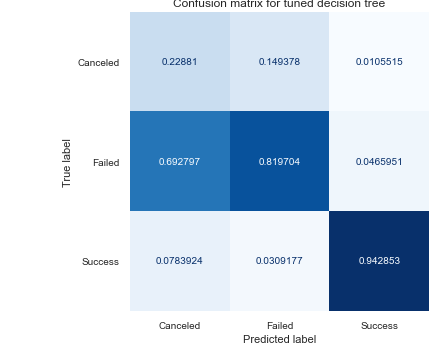

In [68]:
disp = plot_confusion_matrix(random_search_dt, X_test, y_test,
                             display_labels=['Canceled', 'Failed', 'Success'],
                             cmap=plt.cm.Blues, 
                             values_format = 'g',
                             normalize='pred')
disp.ax_.set_title('Confusion matrix for tuned decision tree');

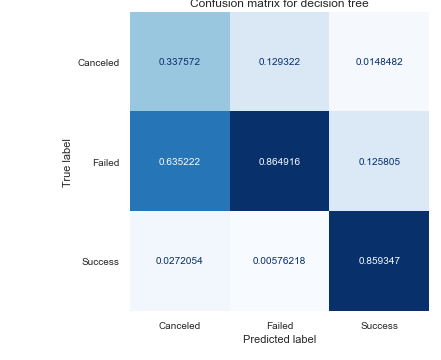

In [76]:
disp = plot_confusion_matrix(dt_pipeline, X_test, y_test,
                             display_labels=['Canceled', 'Failed', 'Success'],
                             cmap=plt.cm.Blues, 
                             values_format = 'g',
                             normalize='pred')
disp.ax_.set_title('Confusion matrix for decision tree');

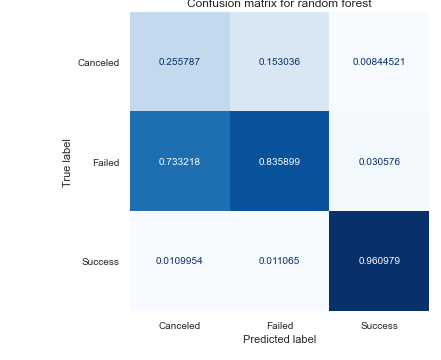

In [75]:
disp = plot_confusion_matrix(rf_pipeline, X_test, y_test,
                             display_labels=['Canceled', 'Failed', 'Success'],
                             cmap=plt.cm.Blues, 
                             values_format = 'g',
                             normalize='pred')
disp.ax_.set_title('Confusion matrix for random forest');

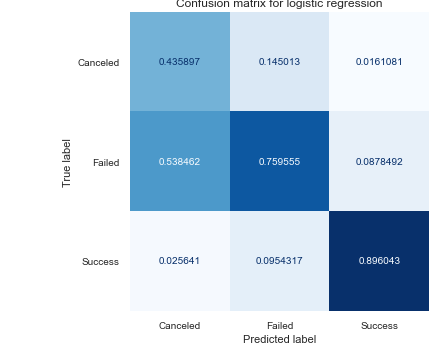

In [73]:
disp = plot_confusion_matrix(lr_pipeline, X_test, y_test,
                             display_labels=['Canceled', 'Failed', 'Success'],
                             cmap=plt.cm.Blues, 
                             values_format = 'g',
                             normalize='pred')
disp.ax_.set_title('Confusion matrix for logistic regression');

## Observations ##
1. The models all do a better job at predicting the true case of the `success` class.
2. They all perform poorly for predicting the "Cancelled" for "Failed" and vice versa.
3. Each model seems to be good at its own niche, for example, the random forest is really good at predicting the true success case, while logistic regression model performs better in terms of the true Cancelled caes. If we do an ensemble of the models, we might be able to get better results, although the prediction for true failed and cancelled classes are still much lower compare to the true success case.
4. This was foresaw from the feature importance coefficients we saw from the LR model.


## Things to think about ##
- Probelm: 
After one hot encoding the categorical features, we now have more than 150 columns as opposed to ~10. This may affect the performance of the model
- Potential solution: Perhaps we can use a different tree (eg. CART) that supports using categorical columns in the stump to avoid OHE?
